In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm

from matplotlib import gridspec
from IPython.display import Image

%matplotlib notebook
plt.style.use('seaborn-white')

color = '#87ceeb'

f_dict = {'size':14}

/Users/vini/.pyenv/versions/3.6.1/envs/curiousily_website/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Calculate Gamma shape and rate from mode and sd.
def gammaShRaFromModeSD(mode, sd):
    rate = (mode + np.sqrt( mode**2 + 4 * sd**2 ) ) / ( 2 * sd**2 )
    shape = 1 + mode * rate
    return(shape, rate)

In [3]:
df = pd.read_csv('states.csv', dtype={'state':'category', 'action':'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 3 columns):
state     12 non-null category
action    12 non-null category
reward    12 non-null int64
dtypes: category(2), int64(1)
memory usage: 256.0 bytes


In [4]:
df

,state,action,reward
0,s1,a1,1
1,s1,a2,100
2,s1,a3,1
3,s2,a1,100
4,s2,a2,1
5,s2,a3,1
6,s3,a1,100
7,s3,a2,1
8,s3,a3,1
9,s4,a1,1


In [5]:
y = df.reward
x1 = df.state.cat.codes.values
x2 = df.action.cat.codes.values
Nx1Lvl = len(df.state.cat.categories)
Nx2Lvl = len(df.action.cat.categories)
Ncell = df.reward.size

yLogMean = np.log(np.sum(y)/(Nx1Lvl*Nx2Lvl))
yLogSD = np.log(np.std(np.r_[np.repeat([0], Ncell-1), np.sum(y)], ddof=1))
agammaShRa = gammaShRaFromModeSD(yLogSD, 2*yLogSD)

with pm.Model() as poisson_model:
        a0 = pm.Normal('a0', yLogMean, tau=1/(yLogSD*2)**2)

        a1SD = pm.Gamma('a1SD', agammaShRa[0], agammaShRa[1])
        a1 = pm.Normal('a1', 0.0, tau=1/a1SD**2, shape=Nx1Lvl)
        
        a2SD = pm.Gamma('a2SD', agammaShRa[0], agammaShRa[1])
        a2 = pm.Normal('a2', 0.0, tau=1/a2SD**2, shape=Nx2Lvl)
        
        a1a2SD = pm.Gamma('a1a2SD', agammaShRa[0], agammaShRa[1])
        a1a2 = pm.Normal('a1a2', 0.0, 1/a1a2SD**2, shape=(Nx1Lvl, Nx2Lvl))
        
        lmbda = pm.math.exp(a0 + a1[x1] + a2[x2] + a1a2[x1, x2])
        
        y = pm.Poisson('y', lmbda, observed=y)

In [6]:
n_samples = 20000
with poisson_model:
    trace1 = pm.sample(n_samples, tune=2500, nuts_kwargs={'target_accept': 0.95}, njobs=None)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/vini/.pyenv/versions/3.6.1/envs/curiousily_website/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1a2, a1a2SD_log__, a2, a2SD_log__, a1, a1SD_log__, a0]
  5%|▌         | 1145/22500 [01:18<24:32, 14.50it/s]/Users/vini/.pyenv/versions/3.6.1/envs/curiousily_website/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vini/.pyenv/versions/3.6.1/envs/curiousily_website/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vini/.pyenv/versions/3.6.1/envs/curiousily_website/lib/python3.6/site-packages/n

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


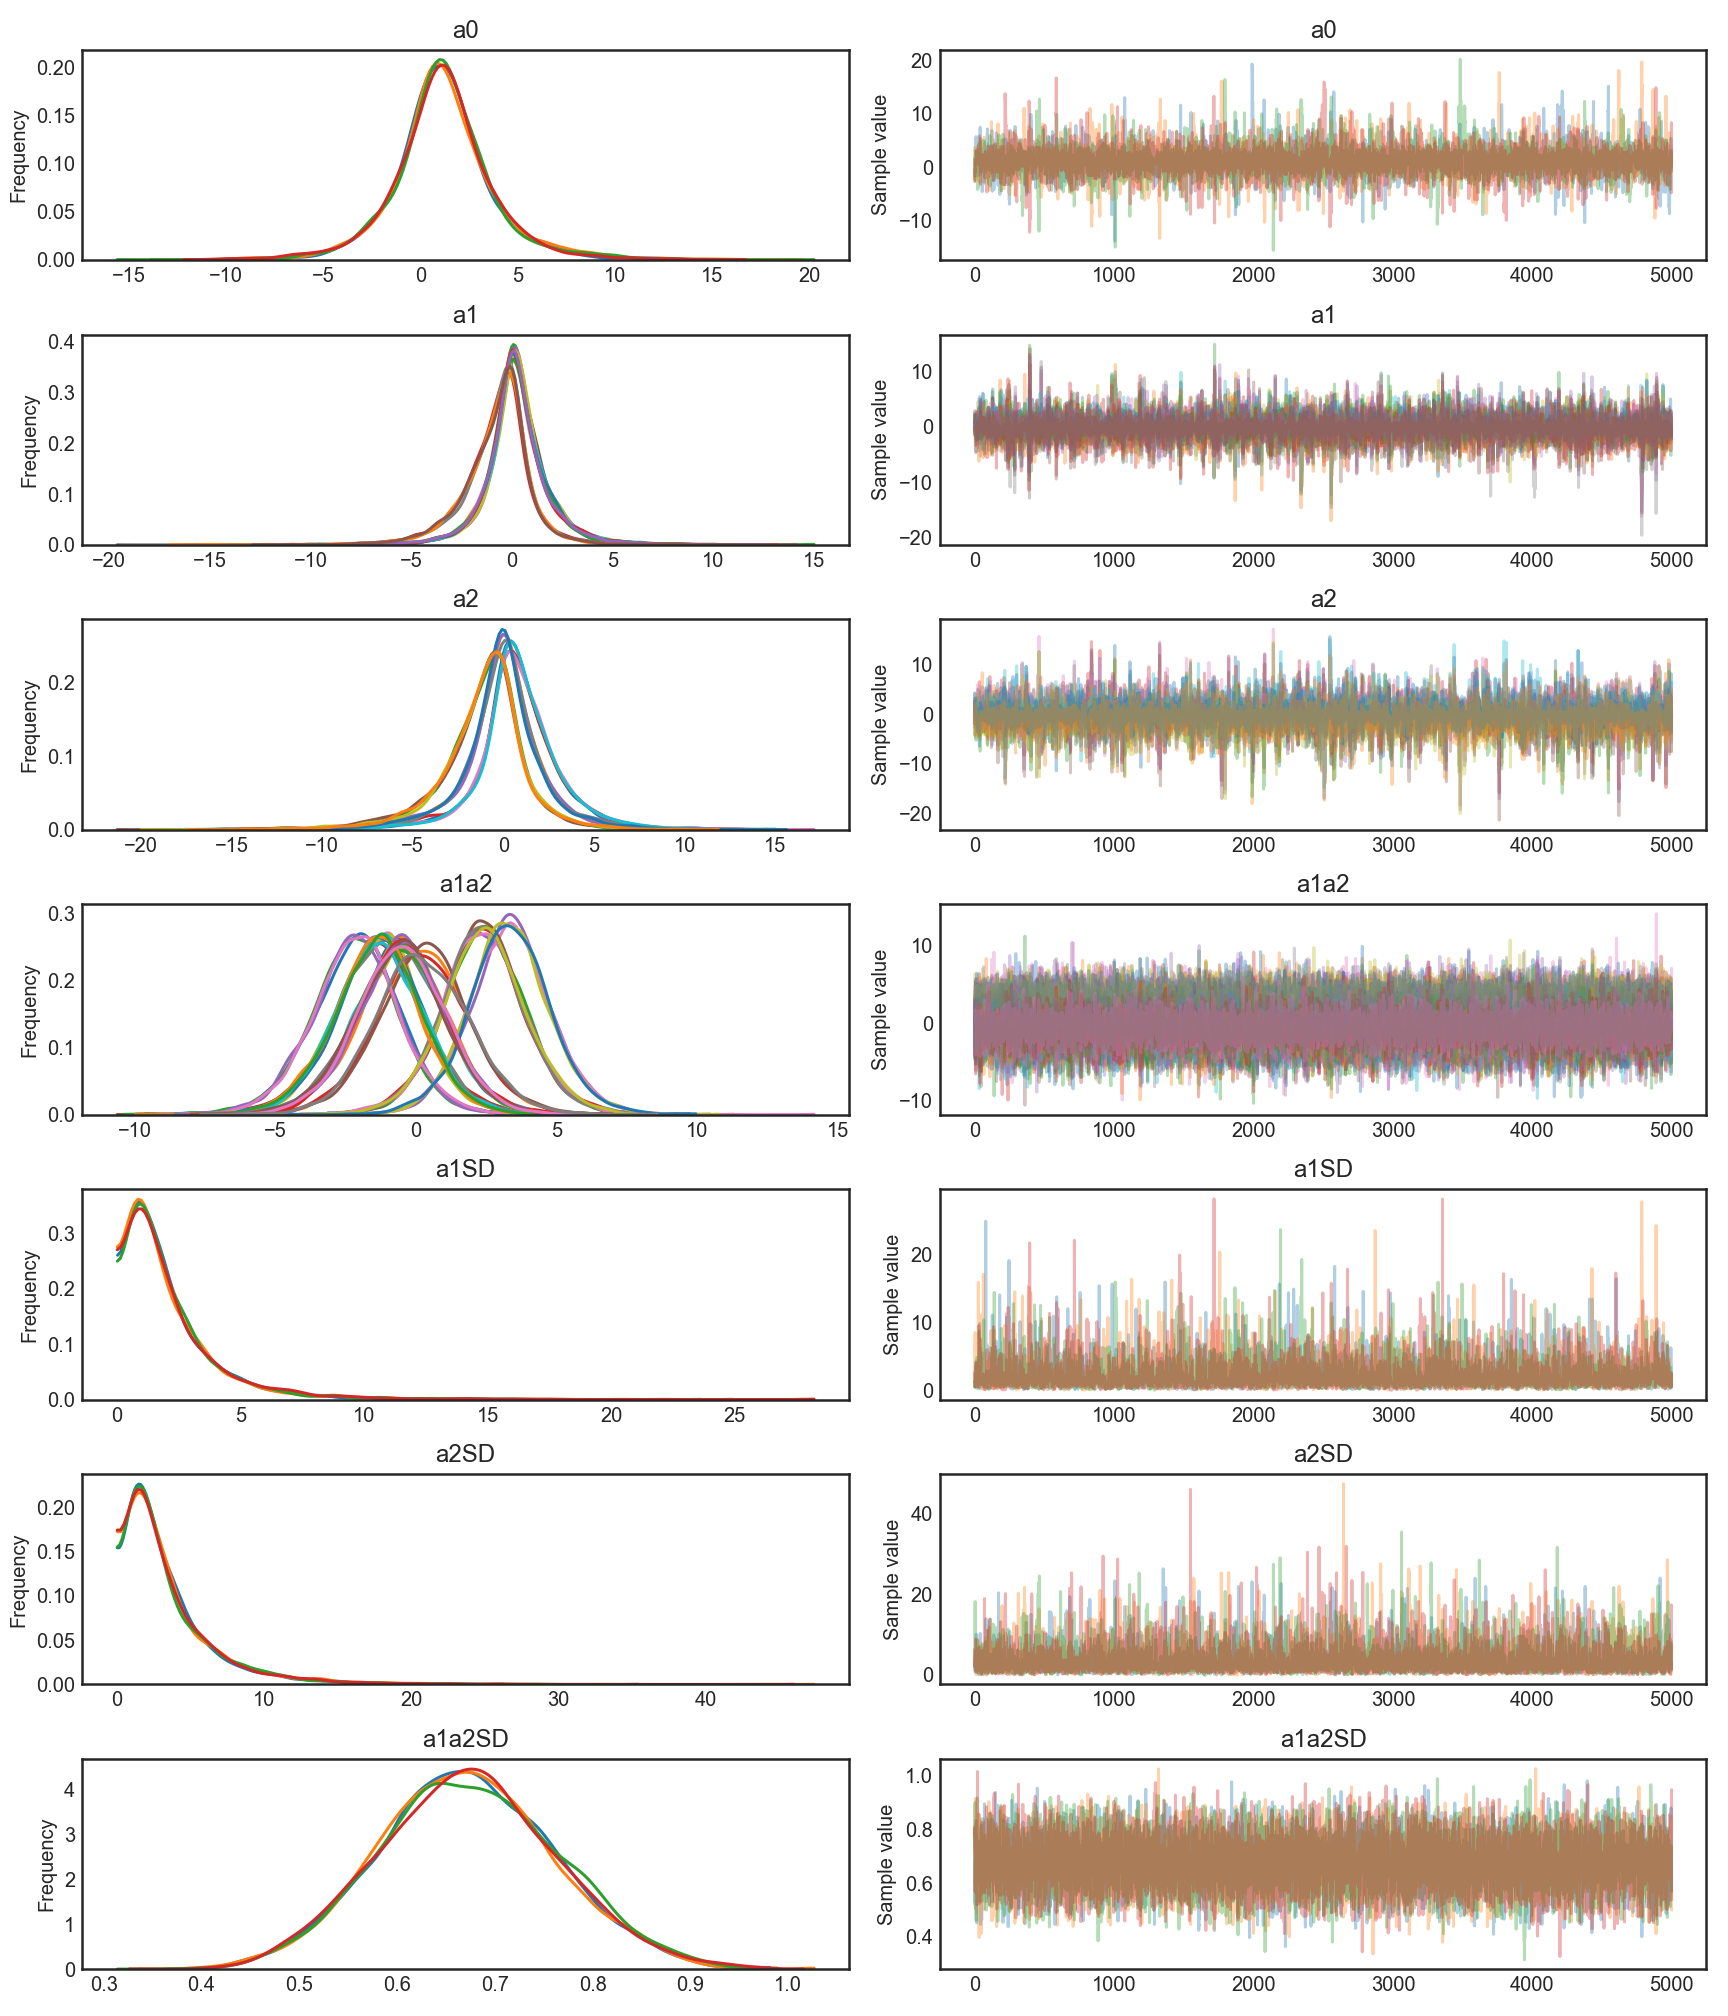

In [8]:
pm.traceplot(trace1);

In [9]:
# Transforming the trace data to sum-to-zero values
m = np.zeros((Nx1Lvl,Nx2Lvl, n_samples))
b1b2 = m.copy()

for (j1,j2) in np.ndindex(Nx1Lvl,Nx2Lvl):
        m[j1,j2] =  (trace1['a0'] +
                     trace1['a1'][:,j1] +
                     trace1['a2'][:,j2] +
                     trace1['a1a2'][:,j1,j2])

b0 = np.mean(m, axis=(0,1))
b1 = np.mean(m, axis=1) - b0
b2 = np.mean(m, axis=0) - b0
        
for (j1,j2) in np.ndindex(Nx1Lvl,Nx2Lvl):
        b1b2[j1,j2] =  (m[j1,j2] - (b0 + b1[j1] + b2[j2]))

# Compute predicted proportions
expm = np.exp(m)
ppx1x2p = expm/np.sum(expm, axis=(0,1))

ValueError: could not broadcast input array from shape (20000) into shape (5000)

# Modeling

In [155]:
ACTION_TL = 1
ACTION_TR = 2
ACTION_BL = 3
ACTION_BR = 4
ACTION_BACK = 5

class State:
    
    def __init__(self, data, action_handlers = dict()):
        self.data = data
        self.action_handlers = action_handlers
    
    def act(self, action):
        if action not in self.action_handlers:
            return None
        return self.action_handlers[action]
    
    def __repr__(self):
        return str(self.data)

class MiniUiEnv:
    
    def __init__(self, states, actions):
        self.states = states
        self.actions = actions
        self.reset()
        self.total_reward = 1 / len(states)
        self.visited_states = set()
        self.visited_states.add(self.state)
    
    def reset(self):
        self.state = self.states[0]
        return self.state, self.actions
        
    def step(self, action):
        visited_cnt = len(self.visited_states)
        handler = self.state.act(action)
        if handler is not None:
            handler(self)
        self.visited_states.add(self.state)
        new_visited_cnt = len(self.visited_states)
        
        reward = 1 / len(self.states) if visited_cnt != new_visited_cnt else 0
        
        self.total_reward += reward
        
        is_done = self.total_reward == 1
        
        return self.state, self.actions, reward, is_done
        
    def _change_state(self, new_state):
        self.state = self.states[new_state - 1]

In [156]:
actions = [ACTION_TL, ACTION_TR, ACTION_BL, ACTION_BR, ACTION_BACK]

In [157]:
s1 = State(
    data=["t", "n", "b", "b"],
    action_handlers={
        ACTION_BL: lambda env : env._change_state(2),
        ACTION_BR: lambda env : env._change_state(3),
    }
)

s2 = State(
    data=["t", "b", "n", "n"],
    action_handlers={
        ACTION_BACK: lambda env: env._change_state(1)
    }
)

s3 = State(
    data=["t", "n", "n", "t"],
    action_handlers={
        ACTION_BACK: lambda env: env._change_state(1)
    }
)

In [158]:
env = MiniUiEnv([s1, s2, s3], actions)

In [164]:
env.reset()

(['t', 'n', 'b', 'b'], [1, 2, 3, 4, 5])

In [165]:
env.step(ACTION_BL)

(['t', 'b', 'n', 'n'], [1, 2, 3, 4, 5], 0, True)

In [166]:
env.step(ACTION_BACK)

(['t', 'n', 'b', 'b'], [1, 2, 3, 4, 5], 0, True)

In [167]:
env.step(ACTION_BR)

(['t', 'n', 'n', 't'], [1, 2, 3, 4, 5], 0, True)

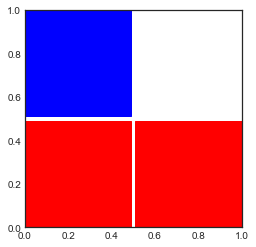

In [182]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig1 = plt.figure()
ax1 = fig1.add_subplot(111, aspect='equal')
ax1.add_patch(
    patches.Rectangle(
        (0.0, 0.0),   # (x,y)
        0.49,          # width
        0.49,          # height
        color='red',
    )
)
ax1.add_patch(
    patches.Rectangle(
        (0.51, 0.0),   # (x,y)
        0.49,          # width
        0.49,          # height
        color='red',
    )
)
ax1.add_patch(
    patches.Rectangle(
        (0.0, 0.51),   # (x,y)
        0.49,          # width
        0.49,          # height
        color='blue',
    )
)